In [3]:
#pip install opencv-python

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt

In [2]:
# Load image
def load_image(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

In [3]:
image_path = r'D:\DOWNLOADS\generated_image.png'

In [4]:
image = load_image(image_path)

In [5]:
# Convert the image from BGR to RGB (as OpenCV loads images in BGR)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

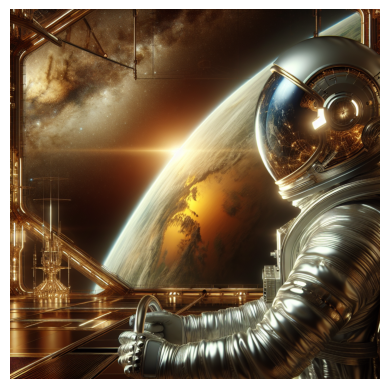

In [6]:
# Display the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes for better view
plt.show()

#### Sharpness using Laplacian variance

- The sharpness of an image can be assessed by calculating the Laplacian variance, which measures the amount of high-frequency content in the image.
- The Laplacian operator highlights edges in the image, which are areas of rapid intensity change.
- By calculating the variance of the Laplacian, we can estimate how sharp (or blurry) the image is.

**Typical Ranges:**

- For a clear, sharp image, Laplacian variance often falls between 500 and 2000.
- For a slightly blurry image, the score might range between 100 and 500.
- For a heavily blurred image, the variance might fall below 100.

**Examples**
- Professional Cameras: High-quality DSLR or mirrorless camera images often have high Laplacian variance scores (typically over 1000), especially for well-focused shots.
- Smartphone or Low-Resolution Images: May have moderate scores (200-800) due to lower resolution and potential noise.
- Blurry Images or Motion Blur: Scores tend to be low (below 100), especially if there is a significant lack of detail.

In [7]:
def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

In [8]:
sharpness = calculate_sharpness(image)

In [9]:
print("Sharpness:", sharpness)

Sharpness: 1672.2079758675736


#### Contrast based on pixel intensity range
- Contrast refers to the difference in brightness between the light and dark areas of an image.
- Higher contrast means a greater difference between dark and light regions, while lower contrast implies a narrower range.
- `Low-Contrast Images` are characterized by limited pixel value variation and can often appear flat.
- `High-Contrast Images` utilize the full range of pixel values, creating strong visual distinctions but potentially sacrificing detail in highlights and shadows.

In [10]:
def calculate_contrast(image):
    min_pixel = np.min(image)
    max_pixel = np.max(image)
    contrast = max_pixel - min_pixel
    return contrast

In [11]:
contrast = calculate_contrast(image)
print("Contrast:", contrast)

Contrast: 255


Converting to Grayscale: The image is converted to grayscale to simplify the histogram analysis, focusing solely on intensity values.

In [12]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

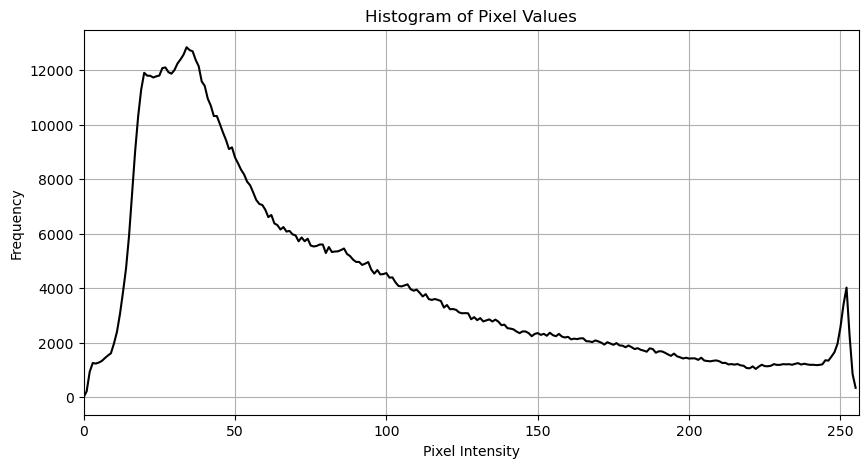

In [13]:
# Compute the histogram
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.plot(hist, color='black')
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])  # Pixel intensity range
plt.grid()
plt.show()

- A histogram that is skewed to the left indicates a low-contrast image (many dark pixels).
- A histogram that is skewed to the right indicates a high-contrast image (many bright pixels).
- A histogram that spans the full range (0-255) suggests good contrast with a balanced distribution of dark and light pixels.

#### Noise estimation using Gaussian filtering

- `Gaussian Kernel`: A matrix that represents the Gaussian distribution. The size of the kernel and the standard deviation (σ) define how much smoothing is applied.

- `Convolution`: The process of sliding the kernel over the image and computing the weighted sum of the pixel values covered by the kernel at each position.

- `Noise Types`:

    - `Gaussian Noise`: Characterized by a normal distribution of pixel values around the true pixel values. It's typically caused by sensor noise.
    - `Salt-and-Pepper Noise`: Randomly occurring white and black pixels in the image.
      
- Choose the `Kernel Size` and `Standard Deviation`
    - The kernel size determines the extent of smoothing. Common choices are 3x3, 5x5, or larger (7x7, 9x9) depending on the noise level and image content.
    - The standard deviation (σ) controls the spread of the Gaussian function. A larger σ results in more blurring.

In [14]:
def calculate_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian filter to smooth the image
    smoothed = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Estimate noise as the absolute difference between original and smoothed image
    noise = np.mean(np.abs(gray - smoothed))
    return noise

In [15]:
noise = calculate_noise(image)
print("Noise:", noise)

Noise: 111.75945854187012


- Low Noise: Values below 50 might indicate a relatively clean image.
- Moderate Noise: Values between 50 and 150 could suggest moderate noise, potentially affecting image quality.
- High Noise: Values above 150 could indicate significant noise, likely impacting subsequent image processing tasks.

#### Structural Similarity Index (SSIM)

- The Structural Similarity Index (SSIM) is a perceptual metric used to evaluate the similarity between two images.

- Key Components of SSIM
    - Luminance: Measures the brightness of the images.
    - Contrast: Assesses the contrast levels in the images.
    - Structure: Evaluates the structural information by considering the patterns of pixel intensities.
      
- The SSIM index ranges from -1 to 1, where:
    - 1 indicates perfect similarity.
    - 0 indicates no similarity.
    - Negative values (rare in practice) indicate that the images are dissimilar.

In [16]:
def calculate_ssim(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Blur the original grayscale image
    blurred = cv2.GaussianBlur(gray, (11, 11), 1)
    
    # Calculate SSIM between original and blurred image
    ssim_score = ssim(gray, blurred)
    return ssim_score

In [19]:
ssim_score = calculate_ssim(image)
print("SSIM:", ssim_score)

SSIM: 0.8509140148091159


#### Overall quality score

In [20]:
def calculate_quality_score(sharpness, contrast, noise, ssim_score):
    # Example weights (adjust based on preference or testing)
    weights = {'sharpness': 0.3, 'contrast': 0.2, 'noise': 0.2, 'ssim': 0.3}
    
    # Normalizing each metric by a predefined maximum value
    quality_score = (
        weights['sharpness'] * (sharpness / 1000) +  # Adjust normalization factor based on expected sharpness range
        weights['contrast'] * (contrast / 255) +
        weights['noise'] * (1 - (noise / 50)) +  # Higher noise lowers quality, hence 1 - noise/50
        weights['ssim'] * ssim_score
    )
    return quality_score

In [21]:
quality_score = calculate_quality_score(sharpness, contrast, noise, ssim_score)
print("Overall Quality Score:", quality_score)

Overall Quality Score: 0.7098987630355263


**Thresholds for Interpretation:**

- Low Quality (0 to 0.3 or 0% to 30%): The image likely suffers from significant issues such as blurriness, low contrast, high noise, or poor structural integrity.
- Moderate Quality (0.3 to 0.7 or 30% to 70%): The image may have some quality issues, but it is still usable. It might be acceptable for certain applications, but enhancements could improve it.
- High Quality (0.7 to 1 or 70% to 100%): The image is clear, well-contrasted, and exhibits minimal noise. It is suitable for high-quality displays or professional use.